In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
df = pd.read_csv('heart_attack_dataset.csv')

In [3]:
# print(df.shape)
# print(df.head())
# categorization of columns for reference
BinaryColumns = ['Smoker', 'Diabetes', 'Hypertension', 'FamilyHistory', 
                'AlcoholConsumption', 'Medication', 'ExerciseInducedAngina', 
                 'PreviousHeartAttack', 'StrokeHistory']
    
ContinuousColumns = ['Age', 'Cholesterol', 'BloodPressure', 'HeartRate', 'BMI', 'PhysicalActivity', 
                     'Income', 'MaxHeartRate', 'ST_Depression', 'NumberOfMajorVessels']
    
CategoricalColumns = ['Gender', 'Diet', 'StressLevel', 'Ethnicity', 
                      'EducationLevel', 'ChestPainType', 'ECGResults', 
                      'Slope', 'Thalassemia', 'Residence', 'EmploymentStatus', 
                      'MaritalStatus']

In [4]:
# extract features
binary_features = df[['Smoker', 'Diabetes', 'Hypertension', 'PreviousHeartAttack', 'StrokeHistory']].values
continuous_features = df[['Age', 'Cholesterol', 'BloodPressure', 'BMI', 'PhysicalActivity']].values
categorical_features = df[['Ethnicity', 'Diet', 'ECGResults', 'StressLevel']]

# one-hot encode categorical features 
categorical_features = pd.get_dummies(categorical_features, drop_first=True).values

# normalize continuos features
scaler = StandardScaler()
continuous_features = scaler.fit_transform(continuous_features)

# combine all features
X = np.concatenate([binary_features, continuous_features, categorical_features], axis=1)

In [5]:

# extract target
y = df['Outcome'].values
# convert 'heartk attack' and 'not heart attack' to binary output
y = (y == 'Heart Attack').astype(int)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

# standardize inputs
scaler = StandardScaler()
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32).view(-1, 1)

X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32).view(-1, 1)

In [6]:
# note: after one hot encoding, each category from each categorical feature becomes its own feature
# therefore, for example, 9 chosen columns could actually mean 14 columns
# remember that when creating the first NN layer!
print(X.shape)

(372974, 19)


In [17]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(19, 1024) # input layer.  note: first input num must match number of input features
        self.fc2 = nn.Linear(1024, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16) 
        self.fc5 = nn.Linear(16, 8)
        self.fc_out = nn.Linear(8, 1)  # last hidden layer to output layer
        self.dropout = nn.Dropout(p=0.0)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # ReLu on hidden layers
        x = torch.relu(self.fc1(x))  
        x = torch.relu(self.fc2(x))   
        x = torch.relu(self.fc3(x))   
        x = torch.relu(self.fc4(x))   
        x = torch.relu(self.fc5(x))   
        x = self.sigmoid(self.fc_out(x)) # sigmoid activiation on output
        return x

In [18]:
# hyper-parameters
learn_rate = 0.1
epochs = 100
# batch_size = 1024

In [19]:
# set GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# instantiate the model, move it to GPU
model = NN().to(device)

# loss function 
criterion = nn.BCELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr = learn_rate)

# train loader for batch training
# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# move training and testing data to GPU
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

print(f'Using device: {device}')

Using device: cuda


In [20]:
# training and validation
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


# batch training
# for epoch in range(epochs):
#     # Training phase
#     model.train()
#     for batch_X, batch_y in train_loader:
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)
#         optimizer.zero_grad()
#         outputs = model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()

for epoch in range(epochs):
    # training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Calculate training accuracy on the entire training set
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train)
        train_predictions = (train_outputs > 0.5).float()
        train_correct = (train_predictions == y_train).float().sum()
        train_accuracy = train_correct / y_train.shape[0]

    # Store training metrics
    train_losses.append(loss.item())
    train_accuracies.append(train_accuracy.item())

    # Validation phase
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        val_predictions = (val_outputs > 0.5).float()
        val_correct = (val_predictions == y_test).float().sum()
        val_accuracy = val_correct / y_test.shape[0]

    # Store validation metrics
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

    # Print metrics every few epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy.item():.4f}, '
              f'Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy.item():.4f}')

Epoch [10/100], Training Loss: 50.0191, Training Accuracy: 0.4998, Validation Loss: 49.3699, Validation Accuracy: 0.5063
Epoch [20/100], Training Loss: 50.0191, Training Accuracy: 0.4998, Validation Loss: 49.3699, Validation Accuracy: 0.5063
Epoch [30/100], Training Loss: 50.0191, Training Accuracy: 0.4998, Validation Loss: 49.3699, Validation Accuracy: 0.5063
Epoch [40/100], Training Loss: 50.0191, Training Accuracy: 0.4998, Validation Loss: 49.3699, Validation Accuracy: 0.5063
Epoch [50/100], Training Loss: 50.0191, Training Accuracy: 0.4998, Validation Loss: 49.3699, Validation Accuracy: 0.5063
Epoch [60/100], Training Loss: 50.0191, Training Accuracy: 0.4998, Validation Loss: 49.3699, Validation Accuracy: 0.5063
Epoch [70/100], Training Loss: 50.0191, Training Accuracy: 0.4998, Validation Loss: 49.3699, Validation Accuracy: 0.5063
Epoch [80/100], Training Loss: 50.0191, Training Accuracy: 0.4998, Validation Loss: 49.3699, Validation Accuracy: 0.5063
Epoch [90/100], Training Loss: 5

Maximum Training Accuracy: 0.4998
Maximum Validation Accuracy: 0.5063


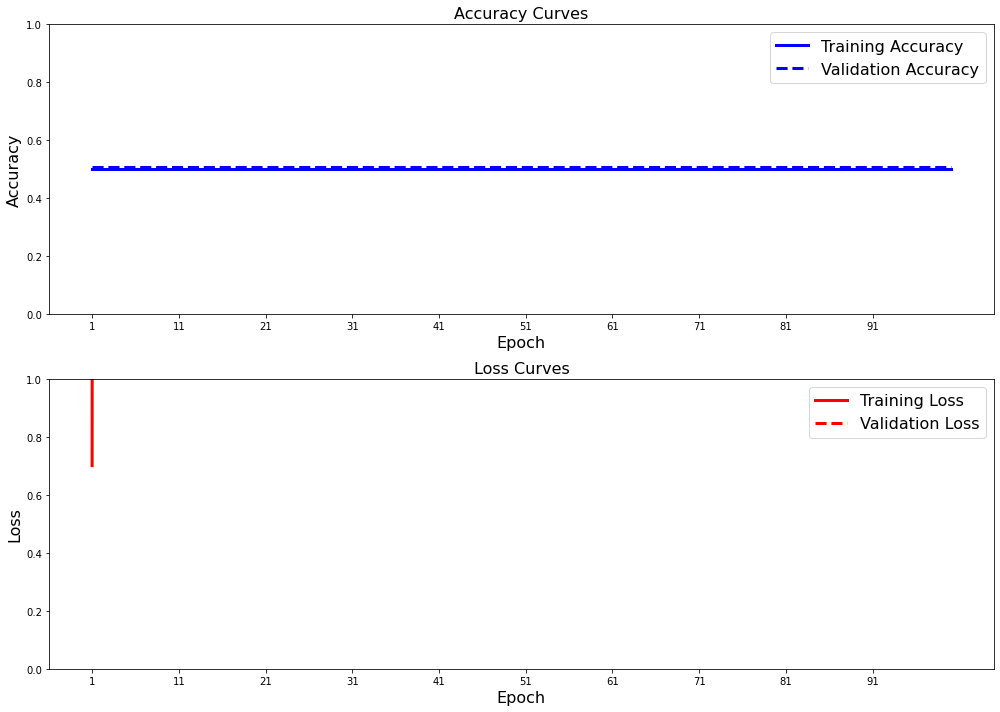

In [21]:
# max accuracies
print(f"Maximum Training Accuracy: {max(train_accuracies):.4f}")
print(f"Maximum Validation Accuracy: {max(val_accuracies):.4f}")

# accuracy curves
plt.figure(figsize=[14, 10])
plt.subplot(2, 1, 1) # note: divides output into 2 rows, 1 col, and this figure has position 1
plt.plot(train_accuracies, 'b', linewidth=3.0, label='Training Accuracy')
plt.plot(val_accuracies, 'b--', linewidth=3.0, label='Validation Accuracy')
plt.legend(fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim(0, 1)
plt.xticks(np.arange(0, epochs, 10), np.arange(1, epochs + 1, 10))
plt.title('Accuracy Curves', fontsize=16)

# loss curves
plt.subplot(2, 1, 2)
plt.plot(train_losses, 'r', linewidth=3.0, label='Training Loss')
plt.plot(val_losses, 'r--', linewidth=3.0, label='Validation Loss')
plt.legend(fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim(0, 1)
plt.xticks(np.arange(0, epochs, 10), np.arange(1, epochs + 1, 10))
plt.title('Loss Curves', fontsize=16)

plt.tight_layout()
plt.show()

In [22]:
print(torch.__version__)

2.6.0+cu124


In [23]:
print(torch.version.cuda)

12.4
